![tent map CMLs](https://media-exp1.licdn.com/dms/image/C4D22AQF5qqMBVPHWHg/feedshare-shrink_1280/0?e=1593043200&v=beta&t=26DxI5bLMUm3eEH9vbRyelF5Z79XAkJwWA9BWdC_3zQ)
# Learning Chaotic Coupled-Map Lattices
Two main goals:
- learning to initialize chaotic systems
- learning to configure chaotic systems (both ICs and BPs)

The first seems to be much easier than the second.

## Todos
- address vanishing gradients for larger timesteps
  - residual connection doesn't seem to solve the problem...
  - could also try a different map function (tanh?)
  - [Shobu-Ose-Mori](http://www.scipress.org/journals/forma/pdf/2801/28010001.pdf) Map is piecewise liear, has stronger grads
  - tent map (would need to be made diffable at center)
  - [smooth generalization](https://www.worldscientific.com/doi/10.1142/S021812741730004X) of tent/logistic
  - [circle map](https://manasataramgini.wordpress.com/2017/11/26/pattern-formation-in-coupled-map-lattices-with-the-circle-map-tanh-map-and-chebyshev-map/)

## Errata
- [role of ICs](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4934879/) in pattern-selection dynamics 

### Imports

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
# To generate GIFs
!pip install -q imageio
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import sys
import cv2

from IPython import display

K = tf.keras.backend
layers = tf.keras.layers

from tensorflow.keras.datasets import mnist

## Constants / Training Parameters

In [0]:
batch_size = 512
BATCH_SIZE = batch_size
num_classes = 10
epochs = 100
EPOCHS = epochs

dynamics = {'chaotic traveling wave': (1.69, 0.5),
            'spatiotemporal intermittency': (1.7522, 0.00115),
            'pattern selection': (1.71, 0.4),
            'no coupling': (1.7522, 0.0),
            'global coupling': (1.7522, 1.0),
            'tent': (0.8, 0.5),
            'local tent': (0.8, 0.0),
            'zero': (0.0, 0.0)}

# input image dimensions
img_rows, img_cols = 28, 28

TIME=10
BP, COUPLING = dynamics['pattern selection']
INITIALIZATION_ACTIVATION = "tanh" # "sigmoid"

## LR Multiplier
- to avoid pandemonium, learn system config slower than system initialization (even w/ optimizers)

In [0]:
!pip install keras-lr-multiplier
TF_KERAS = True
import keras_lr_multiplier.backend
#keras_lr_multiplier.backend.TF_KERAS = True
from keras_lr_multiplier import LRMultiplier

  Created wheel for keras-lr-multiplier: filename=keras_lr_multiplier-0.8.0-cp36-none-any.whl size=5717 sha256=925837f76554f819dcc12e2e1ed638ea03c8f046358c5f05d8962f98d126b7a6
  Stored in directory: /root/.cache/pip/wheels/2a/a5/a4/340d5432bced221b2bcca324e3257239784dd1220ab7c786e9
Successfully built keras-lr-multiplier


Using TensorFlow backend.


## First test: CMLnet
A neural network learns to initialize (and later: bp- and coupling-configure) a coupled map lattice of logistic map units

### Logistic Map
$x_{n+1} = r \cdot x_{n}(1 - x_{n})$

$x_{n+1} = 1 - ax_{n}^{2}$

In [0]:
def kaneko_keras(x, a):
  #print("- Kaneko:\tx: {}\ta: {}".format(x.shape, a.shape))
  return K.ones_like(x) - a * K.square(x)

def identity(x, a):
  return x

def tanh(x, a):
  return K.tanh(x)

# this actually works *better* w/ incorrect domain of [-1, 1]
def tent(x, a):
  return a * (K.ones_like(x) - 2 * K.abs(x - 0.5 * K.ones_like(x)))

MAP_FUNC=kaneko_keras

### Layer Utils
- two-neighbor coupling
- conv-to-dense block
**N.B**: instead of updating the boundaries separately, just _wrap_ them. I.e., make L, C, and R all same-size, with L and R appropriately shifted. 

In [0]:
def two_neighbor_cml(inp):
  x, a, strength = inp
  num_features = K.int_shape(x)[-1]
  batch_size = K.shape(x)[0]

  # update the middle first
  L = x[:, :-2]
  C = x[:, 1:-1]
  R = x[:, 2:]
  a_mid = a[:, :-2]
  str_mid = strength[:, :-2]
  lattice_middle = (1.0 - str_mid) * MAP_FUNC(C, a_mid) + (str_mid/2.0) * (MAP_FUNC(L, a_mid) + MAP_FUNC(R, a_mid))

  # then, update the boundaries
  lattice_left = MAP_FUNC(x[:, 0], a[:, 0])
  lattice_right = MAP_FUNC(x[:, -1], a[:, -1])

  lattice_left = K.reshape(x=lattice_left, shape=(batch_size, 1))
  lattice_right = K.reshape(x=lattice_right, shape=(batch_size, 1))

  return K.concatenate([lattice_left, lattice_middle, lattice_right], axis=-1)


def down_conv_block_with_pooling(inputs, num_output_features, base_sz=64, scope="default"):
  # 2x2 strided conv
  conv_1 = layers.Conv2D(base_sz, (3, 3), strides=(1, 1), padding='same', name=scope + '-c1')(inputs)
  bn_1 = conv_1#tf.layers.BatchNormalization(name=scope + '-bn1')(conv_1)
  relu_1 = layers.ReLU(name=scope + '-lru1')(bn_1)
  pool_1 = layers.MaxPooling2D((2, 2))(relu_1)
  # 2x2 strided conv
  conv_2 = layers.Conv2D(base_sz, (3, 3), strides=(1, 1), padding='same', name=scope + '-c2')(pool_1)
  bn_2 = conv_2#layers.BatchNormalization(name=scope + '-bn2')(conv_2)
  relu_2 = layers.ReLU(name=scope + '-lru2')(bn_2)
  pool_2 = layers.MaxPooling2D((2, 2))(relu_2)
  # flatten
  flat = layers.Flatten(name=scope + '-flt1')(pool_2)
  # dense
  dense = layers.Dense(num_output_features, name=scope + '-d1')(flat)
  drop = layers.Dropout(0.4)(dense)
  return drop  


def down_conv_block(inputs, num_output_features, base_sz=64, scope="default"):

  # 2x2 strided conv
  conv_1 = layers.Conv2D(base_sz, (3, 3), strides=(2, 2), padding='same', name=scope + '-c1')(inputs)
  bn_1 = conv_1#tf.layers.BatchNormalization(name=scope + '-bn1')(conv_1)
  relu_1 = layers.LeakyReLU(name=scope + '-lru1')(bn_1)
  # 2x2 strided conv
  conv_2 = layers.Conv2D(base_sz, (3, 3), strides=(2, 2), padding='same', name=scope + '-c2')(relu_1)
  bn_2 = conv_2#layers.BatchNormalization(name=scope + '-bn2')(conv_2)
  relu_2 = layers.LeakyReLU(name=scope + '-lru2')(bn_2)
  # flatten
  flat = layers.Flatten(name=scope + '-flt1')(relu_2)
  # dense
  dense = layers.Dense(num_output_features, name=scope + '-d1')(flat)
  drop = layers.Dropout(0.4)(dense)
  return drop  

def tile_param_along_lattice(inputs):
  parameter, num_features = inputs
  expanded = K.expand_dims(parameter)
  batch_size = K.shape(parameter)[0]

  tiled = K.tile(expanded, (batch_size, num_features))

  return tiled

### Two-Neighbor Coupled Map Lattice (CML)
Just wrap the entire tf fucntion (slicing included) in a `Lambda` layer...
- may need to apply the update in a loop... that should be fine
- maybe a `TwoNeighborCoupled` layer? applied once, updates once?
```
dense = Flatten()(convs)
for t in range(timesteps):
    dense = TwoNeighborCML()(dense)
```
gradients might be a nightmare, tho kaneko's logistic map itself has a nicely simple gradient

In [0]:
def CML_NN(inputs, NUM_FEATURES=128, timesteps=1, n_classes=10):
  
  # shared conv features
  shared_features = layers.Conv2D(64, (3, 3), padding='same', name="shared")(inputs)
  # get initial lattice conditions
  initial_conditions = down_conv_block_with_pooling(shared_features, NUM_FEATURES, 64, "init")
  # TESTING
  # - sigmoid kills gradient
  # - tanh+relu gets same uniform scale
  initial_conditions = layers.Activation(INITIALIZATION_ACTIVATION, name='initial-conditions')(initial_conditions)

  # get system params (B.P. + coupling strength)
  system_params = down_conv_block(shared_features, 2, 64, "sys")#down_conv_block(shared_features, 2, 64, "sys")
  bp = system_params[:, 0]
  #coupling = layers.Activation("sigmoid")(system_params[1][1])
  coupling = layers.Activation("tanh")(system_params[:, 1])
  coupling = layers.Activation("relu")(coupling)

  # tile bp and coupling to the entire lattice!
  #bp = layers.Lambda(tf.keras.backend.tile, arguments={'n':(-1, NUM_FEATURES)})(bp)
  #coupling = layers.Lambda(tf.keras.backend.tile, arguments={'n':(-1, NUM_FEATURES)})(coupling)
  #bp = layers.RepeatVector(NUM_FEATURES)(bp)
  #coupling = layers.RepeatVector(NUM_FEATURES)(coupling)
  bp = layers.Lambda(tile_param_along_lattice, name="bp-tiling", output_shape=(NUM_FEATURES,))([bp, NUM_FEATURES])
  coupling = layers.Lambda(tile_param_along_lattice, name="coupling-tiling", output_shape=(NUM_FEATURES,))([coupling, NUM_FEATURES])

  # for now, don't learn these.
  bp = K.ones_like(initial_conditions)*BP#system_params[1][0]) * 1.69 #1.7522
  coupling = K.ones_like(initial_conditions)*COUPLING#system_params[1][0]) * 0.5 #0.00115

  system_state = initial_conditions
  
  # evolve CML
  for i in range(timesteps):
    system_state = layers.Lambda(two_neighbor_cml, output_shape=(NUM_FEATURES,), name="lattice-evolution-" + str(i))([system_state, bp, coupling])
  
  # residual connection
  system_state = layers.Add()([system_state, initial_conditions])#system_state + initial_conditions

  #system_state = layers.Dense(128)(system_state)
  #system_state = layers.Activation('relu')(system_state)
  system_state = layers.Dropout(0.5)(system_state)
  decision_dense = layers.Dense(n_classes)(system_state)
  decision_classes = layers.Activation('softmax')(decision_dense)

  return decision_classes



## Training Utils

### Data Preprocessing

In [0]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Callback
Visualizes CML evolution for test data

In [0]:
def plot_cml(cml_data, timesteps, epoch):

  multiple = 5
  num_subplots = cml_data.shape[-2]
  fig, axs = plt.subplots(1, num_subplots)
  fig.set_size_inches(18.5, 10.5)
  
  for i in range(num_subplots):
    cml = cml_data[0, :, i, :]
    # make the timesteps "larger" for easier viewing
    # - (the resize method looks cooler but is more ambiguous)
    #multiple = int(cml.shape[1] / cml.shape[0])
    #cml = np.repeat(cml, repeats=multiple, axis=0)
    cml = cv2.resize(cml, (1024,1024)) 
    axs[i].imshow((cml * 127.5 + 127.5), cmap='magma')
    axs[i].axis('off')
    
  plt.savefig('tmp/{}.png'.format(epoch))

  plt.close()


class viz_cml(tf.keras.callbacks.Callback):
    def __init__(self, model, X_test, timesteps):
        self.model = model
        self.x = X_test
        self.time = timesteps

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        model = self.model
        inp = model.input  # input placeholder
        outputs = []
        outputs.append(model.get_layer('initial-conditions').output)  # get output of N's layer
        for i in range(self.time):
          outputs.append(model.get_layer('lattice-evolution-' + str(i)).output)
        functors = K.function([inp], [outputs])
        layer_outs = functors([self.x, 1.])
        layer_outs = np.array(layer_outs)
        #print('\r OUTPUTS : {}'.format(layer_outs.shape))
        plot_cml(layer_outs, self.time, epoch)
        
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

## Running Training

In [0]:
# CMLnet model
K.clear_session()
cml_input = layers.Input(shape=(img_rows, img_cols, 1))
cml_output = CML_NN(cml_input, 128, TIME)
cml_model = tf.keras.Model(inputs=cml_input, outputs=cml_output)

cml_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
shared (Conv2D)                 (None, 28, 28, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
init-c1 (Conv2D)                (None, 28, 28, 64)   36928       shared[0][0]                     
__________________________________________________________________________________________________
init-lru1 (ReLU)                (None, 28, 28, 64)   0           init-c1[0][0]                    
______________________________________________________________________________________________

### Option 1: `model.fit()`

In [0]:
!mkdir tmp

In [0]:
# Compiling the init-only CML
cml_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

"""
cml_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=LRMultiplier('adam',
                                         {lyr: 0.5 for lyr in [l.name for l in cml_model.layers
                                                               if "sys" in l.name]}),
                  metrics=['accuracy'])
"""
train_history_cml = cml_model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test))#,
                #callbacks=viz_cml(cml_model, x_test[0:3], TIME))

score = cml_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
118/118 [==============================] - 6s 50ms/step - loss: 3.0843 - accuracy: 0.0973 - val_loss: 2.6036 - val_accuracy: 0.0882
Epoch 2/100
118/118 [==============================] - 5s 42ms/step - loss: 2.9348 - accuracy: 0.1055 - val_loss: 2.4256 - val_accuracy: 0.1120
Epoch 3/100
118/118 [==============================] - 5s 42ms/step - loss: 2.8096 - accuracy: 0.1199 - val_loss: 2.3155 - val_accuracy: 0.1395
Epoch 4/100
118/118 [==============================] - 5s 42ms/step - loss: 2.7301 - accuracy: 0.1294 - val_loss: 2.2334 - val_accuracy: 0.1719
Epoch 5/100
118/118 [==============================] - 5s 42ms/step - loss: 2.6463 - accuracy: 0.1409 - val_loss: 2.1548 - val_accuracy: 0.2079
Epoch 6/100
118/118 [==============================] - 5s 42ms/step - loss: 2.5710 - accuracy: 0.1535 - val_loss: 2.0796 - val_accuracy: 0.2599
Epoch 7/100
118/118 [==============================] - 5s 42ms/step - loss: 2.4817 - accuracy: 0.1742 - val_loss: 2.0170 - val_accuracy:

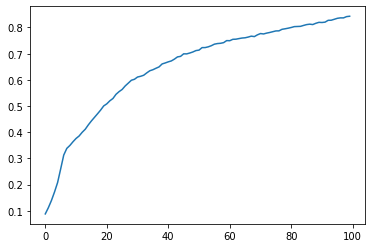

In [0]:
loss = train_history_cml.history['val_accuracy']
#loss_alt = train_history_alt.history['val_loss']
plt.plot(loss)
#plt.plot(loss_alt)
#plt.legend(['val loss (CML)', 'val loss (ReLU)'])
plt.show()

### Generate CML GIF

In [0]:
import imageio

dirName = "tmp/"

gif_images = [imageio.imread(dirName + str(i) + '.png')  for i in range(epochs)]
imageio.mimsave('cml.gif', gif_images)

FileNotFoundError: ignored